<a href="https://colab.research.google.com/github/lineality/DS-Unit-2-Applied-Modeling/blob/master/module3/GGA_2_3_3_assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science
Geoffrey Gordon Ashbrook

*Unit 2, Sprint 3, Module 3*

---
## Dependency Plot

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*


# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    X = X.dropna()

    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
#X_test = test #kaggle test set issues


In [10]:
# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8342046303211351


In [0]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'region_code'

isolate = pdp_isolate(model=pipeline, dataset = X_val, model_features= X_val.columns, feature = feature)

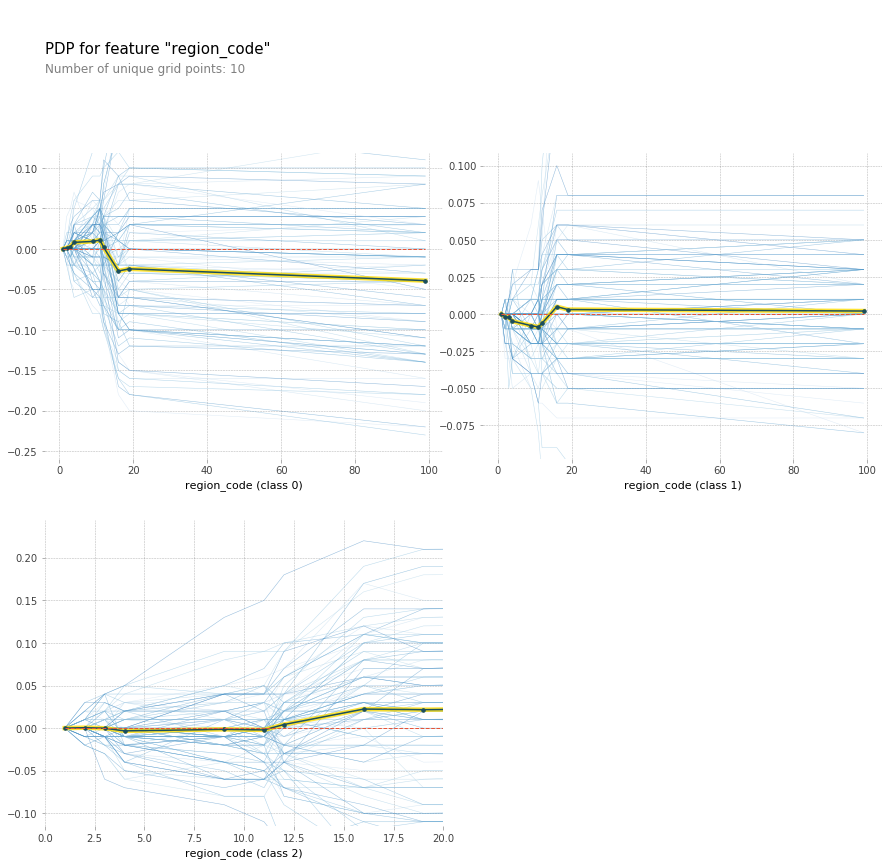

In [22]:
pdp_plot(isolate, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(0,20);

In [0]:
pdp.pdp_plot(pdp_dist, feature);

In [0]:
X_val.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,month_recorded,day_recorded,years
53109,0.0,Churc,1456.0,RC C,35.013890,-8.236533,none,0,Rufiji,I,Iringa,11,2,Mufindi,Sadani,NaN,True,VWC,Uto,True,NaN,ksb,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2011,2,26,2011
7245,0.0,Dh,444.0,DH,37.140807,-6.786685,Kwa Machicha,0,Wami / Ruvu,Mkwajuni,Morogoro,5,1,Kilosa,Kimamba A,140.0,True,VWC,Ki,True,1998.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,2011,2,27,13
52929,0.0,Government Of Tanzania,1165.0,DWE,37.393470,-3.305002,Kwa Neviline Saria,0,Pangani,Osungura,Kilimanjaro,3,4,Moshi Rural,Old Moshi Magharibi,65.0,True,VWC,Kidia kilemapunda,True,1963.0,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,enough,spring,spring,groundwater,other,other,2013,2,23,50
20289,250.0,Oxfarm,1512.0,OXFARM,29.808927,-4.534467,Kwa Abasi,0,Lake Tanganyika,Mhinda Kati,Kigoma,16,2,Kigoma Rural,Mkigo,650.0,True,Water authority,Mroroma,True,2001.0,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,river,river/lake,surface,communal standpipe multiple,communal standpipe,2013,2,3,12
23917,0.0,Wateraid,1352.0,WATERAID,35.169967,-3.972144,Zahanati,0,Internal,Yaeda Kati,Manyara,21,3,Mbulu,Yaeda Chini,186.0,True,VWC,ENDANANG'WENI SPRING,True,2012.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2013,1,31,1


In [0]:
X_val.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,month_recorded,day_recorded,years
53109,0.0,Churc,1456.0,RC C,35.013890,-8.236533,none,0,Rufiji,I,Iringa,11,2,Mufindi,Sadani,NaN,True,VWC,Uto,True,NaN,ksb,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2011,2,26,2011
7245,0.0,Dh,444.0,DH,37.140807,-6.786685,Kwa Machicha,0,Wami / Ruvu,Mkwajuni,Morogoro,5,1,Kilosa,Kimamba A,140.0,True,VWC,Ki,True,1998.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,2011,2,27,13
52929,0.0,Government Of Tanzania,1165.0,DWE,37.393470,-3.305002,Kwa Neviline Saria,0,Pangani,Osungura,Kilimanjaro,3,4,Moshi Rural,Old Moshi Magharibi,65.0,True,VWC,Kidia kilemapunda,True,1963.0,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,enough,spring,spring,groundwater,other,other,2013,2,23,50
20289,250.0,Oxfarm,1512.0,OXFARM,29.808927,-4.534467,Kwa Abasi,0,Lake Tanganyika,Mhinda Kati,Kigoma,16,2,Kigoma Rural,Mkigo,650.0,True,Water authority,Mroroma,True,2001.0,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,river,river/lake,surface,communal standpipe multiple,communal standpipe,2013,2,3,12
23917,0.0,Wateraid,1352.0,WATERAID,35.169967,-3.972144,Zahanati,0,Internal,Yaeda Kati,Manyara,21,3,Mbulu,Yaeda Chini,186.0,True,VWC,ENDANANG'WENI SPRING,True,2012.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2013,1,31,1


In [15]:
X_val.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,month_recorded,day_recorded,years
53109,0.0,Churc,1456.0,RC C,35.013890,-8.236533,none,0,Rufiji,I,Iringa,11,2,Mufindi,Sadani,NaN,True,VWC,Uto,True,NaN,ksb,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2011,2,26,2011
7245,0.0,Dh,444.0,DH,37.140807,-6.786685,Kwa Machicha,0,Wami / Ruvu,Mkwajuni,Morogoro,5,1,Kilosa,Kimamba A,140.0,True,VWC,Ki,True,1998.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,2011,2,27,13
52929,0.0,Government Of Tanzania,1165.0,DWE,37.393470,-3.305002,Kwa Neviline Saria,0,Pangani,Osungura,Kilimanjaro,3,4,Moshi Rural,Old Moshi Magharibi,65.0,True,VWC,Kidia kilemapunda,True,1963.0,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,enough,spring,spring,groundwater,other,other,2013,2,23,50
20289,250.0,Oxfarm,1512.0,OXFARM,29.808927,-4.534467,Kwa Abasi,0,Lake Tanganyika,Mhinda Kati,Kigoma,16,2,Kigoma Rural,Mkigo,650.0,True,Water authority,Mroroma,True,2001.0,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,river,river/lake,surface,communal standpipe multiple,communal standpipe,2013,2,3,12
23917,0.0,Wateraid,1352.0,WATERAID,35.169967,-3.972144,Zahanati,0,Internal,Yaeda Kati,Manyara,21,3,Mbulu,Yaeda Chini,186.0,True,VWC,ENDANANG'WENI SPRING,True,2012.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2013,1,31,1


# not running after this point

In [0]:
# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X_train)

model = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
model.fit(X_encoded, y_train)

In [0]:
X_encoded.isnull().sum()

[Animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/pdp.html#examples)

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)


In [0]:
X_train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,month_recorded,day_recorded,years
53251,0.0,Finw,218.0,FinW,39.673635,-10.835281,Pachani,0,Ruvuma / Southern Coast,Mnyekehe,Mtwara,9,4,Tandahimba,Naputa,260.0,True,Water Board,Borehole,True,1982.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,2013,1,27,31
26791,500.0,Adb,1704.0,DWE,34.915589,-9.016965,Kwa Mwangayange Mfumbilwa,0,Rufiji,Ndanula,Iringa,11,4,Njombe,Igongolo,40.0,True,VWC,Ibiki gravity water scheme,False,2008.0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2011,2,27,3
2162,200.0,Dwe,1232.0,DWE,30.332034,-4.308921,Kwa Bungwa,0,Lake Tanganyika,Nyakerera,Kigoma,16,2,Kasulu,Kitagata,500.0,True,Water authority,Nyachenda,True,2003.0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2013,1,18,10
58277,0.0,Government Of Tanzania,1164.0,District council,37.621413,-3.327062,Kwa Felisian Tarimo,0,Pangani,Mawanda,Kilimanjaro,3,1,Rombo,Mamsera,1.0,True,Company,Hakwe water supply,True,1974.0,gravity,gravity,gravity,company,commercial,pay monthly,monthly,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2013,3,7,39
42209,0.0,Tasaf,1723.0,DWE,36.740534,-3.322409,Kwa Barakaheri Charles,0,Pangani,Engikaleti,Arusha,2,2,Arusha Rural,Bangata,200.0,True,VWC,Bangata water project,True,2007.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2013,3,13,6


In [0]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
# X that you want to look at
feature = 'quantity'
# everything not target
features=X_train.columns
pdp_dist = pdp.pdp_isolate(model=pipeline1, dataset=X_val, model_features=X_val.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [0]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'latitude'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [0]:
# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    #SimpleImputer(strategy='mean'), 
    XGBRegressor(n_estimators=50, objective='reg:squarederror', n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

### Fit Gradient Boosting model

In [0]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=50, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

In [0]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.TargetEncoder(),  
    StandardScaler(), 
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

In [0]:
#target = train_labels['status_group']
#features = ['gps_height', 'longitude', 'latitude', 'region_code']
#X_train = train_features[features]
#y_train = my_train[target]
#X_val = my_val[features]
#y_val = my_val[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

KeyboardInterrupt: ignored

In [0]:
model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train)
model.score(X_val_scaled, y_val)